In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from brainiak import io # need to use mybrainiak environment
from brainiak.fcma.preprocessing import prepare_mvpa_data
from brainiak.fcma.preprocessing import generate_epochs_info
np.warnings.filterwarnings('ignore')
%matplotlib inline

### Stimulus-evoked activity pattern analyses on Cognitive State distinction (Perception vs. Retrieval)

In [2]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '../data/epoch_files/allconds_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '../data/cluster_evoked_activity'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_condition = np.tile(np.repeat(['PerceiveScrambled', 'Retrieve', 'Perceive'],16),24)

epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_epoch_cond = epoch_condition[epoch_start: epoch_start + epochs_per_subj]
    for e, cond in zip(epoch, sub_epoch_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        run_identity = [np.unique(cond_identity[start:start+8])[0] for start in list(np.arange(0,48,8))]

        # face epoch in 6 runs (each run has 4 face epochs)
        sub_epoch = {}
        for idx, cond in enumerate(run_identity):
            start = 8*idx
            if idx % 2 == 0:
                sub_epoch[f'{cond}_run1'] = sub_raw_data_list[start: start + 8]
            else: 
                sub_epoch[f'{cond}_run2'] = sub_raw_data_list[start: start + 8]
        
        within_state_ps_perROI.append(np.mean([compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Retrieve_run2']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['Perceive_run2']),
                                               compute_ps(sub_epoch['PerceiveScrambled_run1'],sub_epoch['PerceiveScrambled_run2']),
                                      np.mean([compute_ps(sub_epoch['Perceive_run1'],sub_epoch['PerceiveScrambled_run1']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['PerceiveScrambled_run2']),
                                               compute_ps(sub_epoch['Perceive_run2'],sub_epoch['PerceiveScrambled_run1']),
                                               compute_ps(sub_epoch['Perceive_run2'],sub_epoch['PerceiveScrambled_run2'])])
                                              ]))
                                               
        
        between_state_ps_perROI.append(np.mean([compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Perceive_run1']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Perceive_run2']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['PerceiveScrambled_run1']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['PerceiveScrambled_run2']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['Perceive_run1']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['Perceive_run2']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['PerceiveScrambled_run1']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['PerceiveScrambled_run2'])
                                               ]))
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC",
       "Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['cogState_index'] =  df['within_state_ps'] - df['between_state_ps']

df_cogState = df.copy(deep = True)
#df_cogState.to_csv('patternSimilarity_results/evokedAct_cogState_idx.csv', index = False)

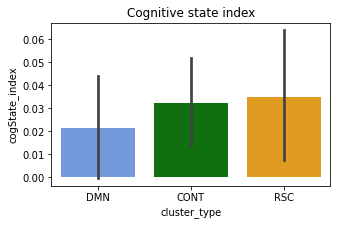

In [8]:
# ----------------------
# Community level plot 
# ----------------------
df_cogState_net = df_cogState.groupby(['cluster_type', 'sub_id']).mean().reset_index()

fig = plt.figure(figsize = (5, 3))
sns.barplot(x="cluster_type", y="cogState_index", order = ['DMN', 'CONT', 'RSC'],
            palette=["cornflowerblue", "green", "orange"], data=df_cogState_net).set_title('Cognitive state index')
plt.show()

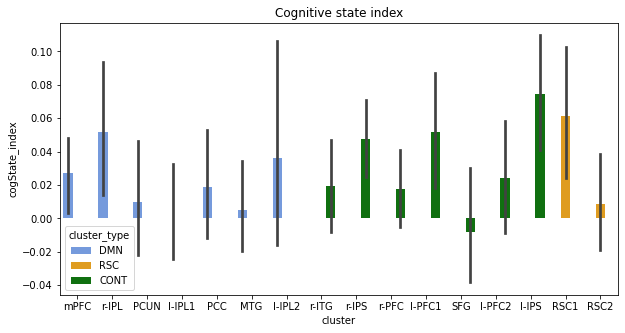

In [10]:
# --------------------
# Cluster level plot 
# --------------------
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="cogState_index", hue='cluster_type', order = order, palette=["cornflowerblue", "orange", "green"], data=df_cogState).set_title('Cognitive state index')
plt.show()

In [14]:
# use another environment for loading pingouin
import pingouin as pg
import pandas as pd

df_cogState = pd.read_csv("patternSimilarity_results/evokedAct_cogState_idx.csv")
df_cogState_net = df_cogState.groupby(['cluster_type', 'sub_id']).mean().reset_index()
print("----Cognitive state distinction MVPA anova-----")
pg.rm_anova(df_cogState_net, dv = "cogState_index", within = ['cluster_type'], subject="sub_id")

----Cognitive state distinction MVPA anova-----


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cluster_type,2,46,0.604107,0.55084,0.025593,0.760326


### Stimulus-evoked activity pattern analyses on Behavioral-task distinction (Male/Female vs. Natural/Manmade task)

In [12]:
# load in epoch file
epoch_file = '../data/epoch_files/faceTask_sceneTask_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '../data/cluster_evoked_activity'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('../data/epoch_files/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceTask_cond = faceTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneTask_cond = sceneTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceTask_cond + sub_sceneTask_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    #within_state_ps_persub = []
    #between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject
        within_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])]),
                                       np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]),
                                                np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))
# 
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['task_index'] =  df['within_state_ps'] - df['between_state_ps']

df_taskState = df.copy(deep = True)
#df_taskState.to_csv('patternSimilarity_results/evokedAct_taskState_idx.csv', index = False)

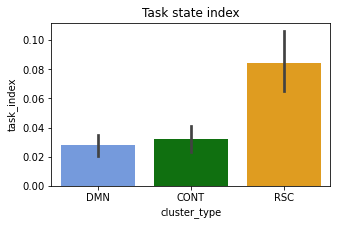

In [13]:
# ----------------------
# Community level plot 
# ----------------------
df_taskState_net = df_taskState.groupby(['cluster_type', 'sub_id']).mean().reset_index()

fig = plt.figure(figsize = (5, 3))
sns.barplot(x="cluster_type", y="task_index", order = ['DMN', 'CONT', 'RSC'],
            palette=["cornflowerblue", "green", "orange"], data=df_taskState_net).set_title('Task state index')
plt.show()

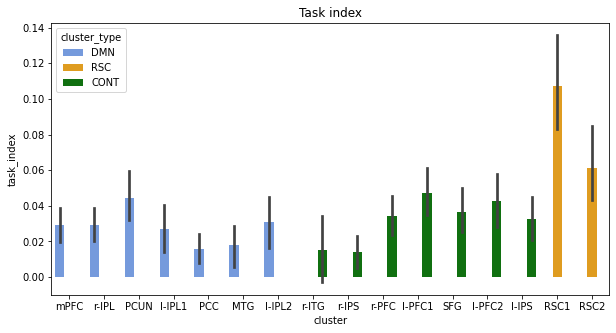

In [14]:
# --------------------
# Cluster level plot 
# --------------------
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="task_index", hue='cluster_type', order = order, 
            palette=["cornflowerblue", "orange", "green"], data=df_taskState).set_title('Task index')
plt.show()

In [12]:
df_taskState = pd.read_csv("patternSimilarity_results/evokedAct_taskState_idx.csv")
df_taskState_net = df_taskState.groupby(['cluster_type', 'sub_id']).mean().reset_index()
print("----Behavioral task distinction MVPA anova-----")
pg.rm_anova(df_taskState_net, dv = "task_index", within = ['cluster_type'], subject="sub_id")

----Behavioral task distinction MVPA anova-----


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cluster_type,2,46,26.920471,1.816899e-08,0.539267,0.592315


In [15]:
print("----Behavioral task MVPA index, RSC vs. DMN----")
pg.ttest(df_taskState_net.loc[df_taskState_net['cluster_type'] == "RSC", "task_index"].tolist(),
df_taskState_net.loc[df_taskState_net['cluster_type'] == "DMN", "task_index"].tolist(), paired = True)

----Behavioral task MVPA index, RSC vs. DMN


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.699851,23,two-sided,0.000008,"[0.04, 0.08]",1.377045,2554.426,1.0


In [17]:
print("----Behavioral task MVPA index, RSC vs. Cont----")
pg.ttest(df_taskState_net.loc[df_taskState_net['cluster_type'] == "RSC", "task_index"].tolist(),
df_taskState_net.loc[df_taskState_net['cluster_type'] == "CONT", "task_index"].tolist(), paired = True)

----Behavioral task MVPA index, RSC vs. Cont


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.996799,23,two-sided,0.000047,"[0.03, 0.07]",1.251221,533.623,0.999952


### Stimulus-evoked activity pattern analyses on Visual content distinction (Face vs. Scene)

In [3]:
# load in epoch file
epoch_file = '../data/epoch_files/faceCue_sceneCue_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '../data/cluster_evoked_activity'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('../data/epoch_files/block_image_identity.csv')
faceCue_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneCue_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()

epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceCue_cond = faceCue_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneCue_cond = sceneCue_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceCue_cond + sub_sceneCue_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    #within_state_ps_persub = []
    #between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject   
        within_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])]),
                                       np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]),
                                                np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))

# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['vis_index'] =  df['within_state_ps'] - df['between_state_ps']
df_visState = df.copy(deep = True)
df_visState.to_csv('patternSimilarity_results/evokedAct_visState_idx.csv', index = False)

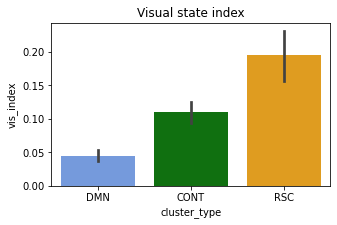

In [4]:
# ----------------------
# Community level plot 
# ----------------------
df_visState_net = df_visState.groupby(['cluster_type', 'sub_id']).mean().reset_index()

fig = plt.figure(figsize = (5, 3))
sns.barplot(x="cluster_type", y="vis_index", order = ['DMN', 'CONT', 'RSC'],
            palette=["cornflowerblue", "green", "orange"], data=df_visState_net).set_title('Visual state index')
plt.show()

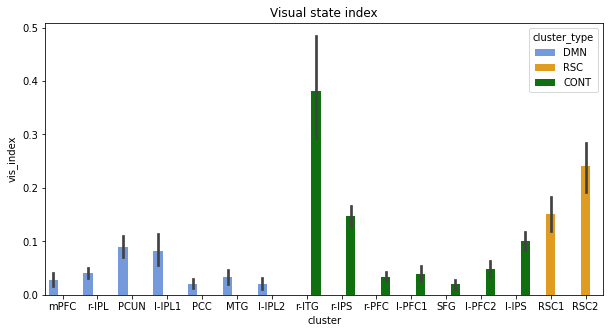

In [5]:
# --------------------
# Cluster level plot 
# --------------------
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="vis_index", hue='cluster_type', order = order, 
            palette=["cornflowerblue", "orange", "green"], data=df_visState).set_title('Visual state index')
plt.show()

In [2]:
df_visState = pd.read_csv("patternSimilarity_results/evokedAct_visState_idx.csv")
df_visState_net = df_visState.groupby(['cluster_type', 'sub_id']).mean().reset_index()
print("----Visual content distinction MVPA anova-----")
pg.rm_anova(df_visState_net, dv = "vis_index", within = ['cluster_type'], subject="sub_id")

----Visual content distinction MVPA anova-----


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cluster_type,2,46,48.349869,4.916965e-12,0.677645,0.650159


In [3]:
print("----Visual content MVPA index, RSC vs. DMN----")
pg.ttest(df_visState_net.loc[df_visState_net['cluster_type'] == "RSC", "vis_index"].tolist(),
df_visState_net.loc[df_visState_net['cluster_type'] == "DMN", "vis_index"].tolist(), paired = True)

----Visual content MVPA index, RSC vs. DMN----


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.018351,23,two-sided,5.173409e-09,"[0.12, 0.19]",2.257316,2.378e+06,1.0


In [4]:
print("----Visual content MVPA index, RSC vs. CONT----")
pg.ttest(df_visState_net.loc[df_visState_net['cluster_type'] == "RSC", "vis_index"].tolist(),
df_visState_net.loc[df_visState_net['cluster_type'] == "CONT", "vis_index"].tolist(), paired = True)

----Visual content MVPA index, RSC vs. CONT----


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.518988,23,two-sided,0.000154,"[0.05, 0.13]",1.20594,183.437,0.999887
